# Exercise 11
## Lars Kühmichel, Nicolas Wolf

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm.notebook import tqdm
import time

In [2]:
plt.rc("figure", dpi=150)
plt.rc("legend", fontsize=6)

device = "cuda"

## Task 1 - Training on Chaotic Data

In [242]:
def plot3D(data, ax=None, label=None):
    ''' Makes a 3D plot of data with dimensions (time x 3)'''
    if ax is None:
        fig = plt.figure()
        ax = fig.add_subplot(projection='3d')
    data_ = data.detach().cpu().numpy()
    ax.plot(data_[:,0], data_[:,1], data_[:,2], lw=0.5, label=label)
    return ax
    
def plot_generated(data, model):
    ''' Generates a time series of the same length as data and plots them against each other '''
    h0 = torch.randn((1, model.latent_dim), device=device)
    gen = model.generate(data.shape[0], data[:1].to(device), h0)
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax = plot3D(data, ax)
    ax = plot3D(gen, ax)
    return ax, gen


class latent_RNN(nn.Module):
    def __init__(self, obs_dim, latent_dim):
        super().__init__()
        self.obs_dim = obs_dim
        self.latent_dim = latent_dim
        self.RNN = nn.RNN(obs_dim, latent_dim, nonlinearity='relu')
        self.observation_model = nn.Linear(latent_dim, obs_dim)        

    def forward(self, time_series, h0):
        rnn_output, h = self.RNN(time_series, h0)
        obs_output = self.observation_model(rnn_output)
        return obs_output, h
    
    def generate(self, T, x0, h0, progress_bar=True):
        prediction = torch.zeros((T, self.obs_dim))
        x = x0.unsqueeze(1)
        h = h0.unsqueeze(1)
        if progress_bar:
            pbar = tqdm(range(T))
        else:
            pbar = range(T)
        for t in pbar:
            prediction[t] = x.squeeze().detach().cpu()
            x, h = self(x, h)
        return prediction


class latent_LSTM(nn.Module):
    def __init__(self, obs_dim, latent_dim):
        super().__init__()
        self.obs_dim = obs_dim
        self.latent_dim = latent_dim
        self.LSTM = nn.LSTM(obs_dim, latent_dim)
        self.observation_model = nn.Linear(latent_dim, obs_dim)        

    def forward(self, time_series, h0, c0):
        rnn_output, (h, c) = self.LSTM(time_series, (h0, c0))
        obs_output = self.observation_model(rnn_output)
        return obs_output, (h, c)
    
    def generate(self, T, x0, h0, progress_bar=True):
        prediction = torch.zeros((T, self.obs_dim))
        x = x0.unsqueeze(1)
        h = h0.unsqueeze(1)
        c = torch.randn(h.shape, device=device)
        if progress_bar:
            pbar = tqdm(range(T))
        else:
            pbar = range(T)
        for t in pbar:
            prediction[t] = x.squeeze().detach().cpu()
            x, (h, c) = self(x, h, c)
        return prediction


class latent_GRU(nn.Module):
    def __init__(self, obs_dim, latent_dim):
        super().__init__()
        self.obs_dim = obs_dim
        self.latent_dim = latent_dim
        self.GRU = nn.GRU(obs_dim, latent_dim)
        self.observation_model = nn.Linear(latent_dim, obs_dim)        

    def forward(self, time_series, h0):
        rnn_output, h = self.GRU(time_series, h0)
        obs_output = self.observation_model(rnn_output)
        return obs_output, h
    
    def generate(self, T, x0, h0, progress_bar=True):
        prediction = torch.zeros((T, self.obs_dim))
        x = x0.unsqueeze(1)
        h = h0.unsqueeze(1)
        if progress_bar:
            pbar = tqdm(range(T))
        else:
            pbar = range(T)
        for t in pbar:
            prediction[t] = x.squeeze().detach().cpu()
            x, h = self(x, h)
        return prediction

def train(model, data, epochs, seq_per_epoch, seq_length, L1_reg_strength, plot_loss=True):
    ''' Automatically uses MSE Loss, Adam Optimizer and L1 regularization '''
    
    loss_function = nn.MSELoss()
    optimizer = optim.Adam(model.parameters())
    
    model.train()
    
    loss_over_time = []
    t0 = time.time()
    pbar = tqdm(range(epochs))
    for i in pbar:
        optimizer.zero_grad()
        
        random_indices = torch.randperm(data.shape[0] - seq_length)[:seq_per_epoch]
        x = torch.cat([data[r:r+seq_length].unsqueeze(1) for r in random_indices], dim=1).to(device)
        y = torch.cat([data[r+1:r+seq_length+1].unsqueeze(1) for r in random_indices], dim=1).to(device)
        h0 = torch.randn((1, seq_per_epoch, model.latent_dim), device=device)
        
        if isinstance(model, latent_LSTM):
            c0 = torch.randn((1, seq_per_epoch, model.latent_dim), device=device)
            output, _ = model(x, h0, c0)        
        else:
            output, _ = model(x, h0)        
        
        model_loss = loss_function(output, y)
        reg_loss = torch.tensor(0., device=device)
        if L1_reg_strength > 0:
            for name, param in model.named_parameters():
                if 'bias' in name:
                    continue
                reg_loss += param.abs().mean()
            reg_loss *= L1_reg_strength
        epoch_loss = model_loss + reg_loss
        
        epoch_loss.backward()
        optimizer.step()
        if i % 10 == 0 and i>0:
            t1 = time.time()
            epochs_per_sec = 10/(t1 - t0) 
            pbar.set_description(f"Epoch: {i} loss {epoch_loss.item():.4f} @ {epochs_per_sec:.4f} epochs per second")
            loss_over_time.append((model_loss.item(), reg_loss.item()))
            t0 = t1
            
    if plot_loss:
        plt.figure()
        plt.plot(torch.tensor(loss_over_time))
        plt.yscale('log')
        plt.legend(('model', 'regul'))
        plt.title('Loss')
        plt.savefig('Losses', dpi=500)
        
    return model, loss_over_time
        


### a) plot data

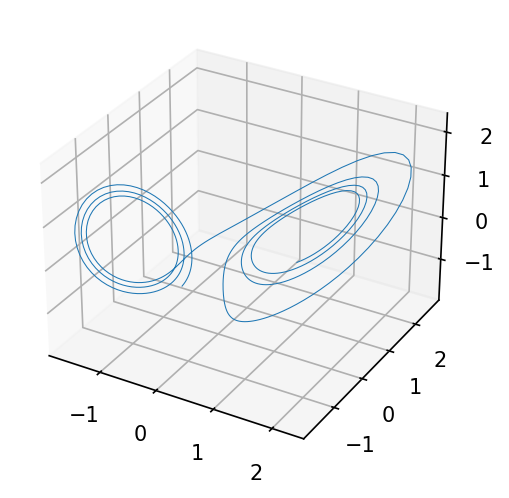

In [218]:
data = torch.load('lorenz63.pt')
observation_size = data.shape[1]

plot3D(data[:500])
plt.show()

### b) 

The sequence length was chosen, such that a trajectory of this length contains $\approx3$ cycles but may also contain a transition to the other fixed point. The regularization strength was chosen similar to last week's exercise.

  0%|          | 0/15000 [00:00<?, ?it/s]

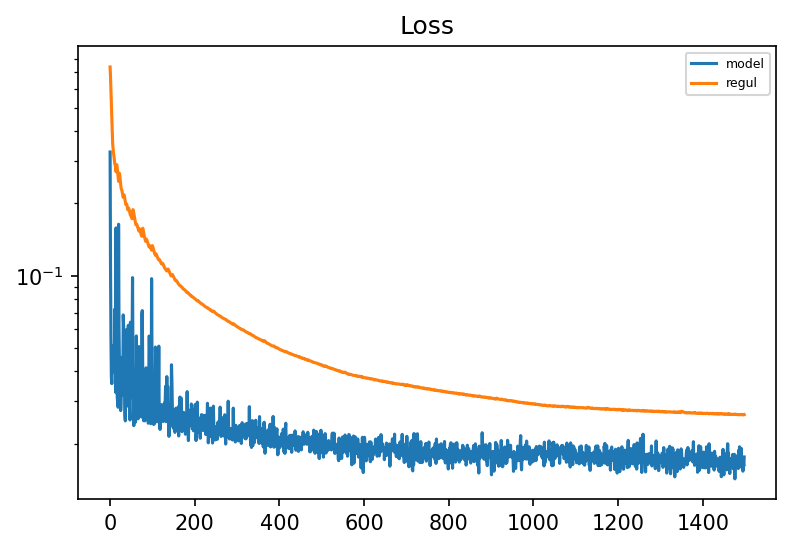

In [265]:
hidden_size = 300
learning_rate = 0.1
L1_reg_strength = 10
epochs = 15000
seq_per_epoch = 200
seq_length = 200


model = latent_RNN(observation_size, hidden_size).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
loss_function = nn.MSELoss()

model, loss_over_time = train(model, data.to(device), epochs, seq_per_epoch, seq_length, L1_reg_strength, plot_loss=True)


  0%|          | 0/100000 [00:00<?, ?it/s]

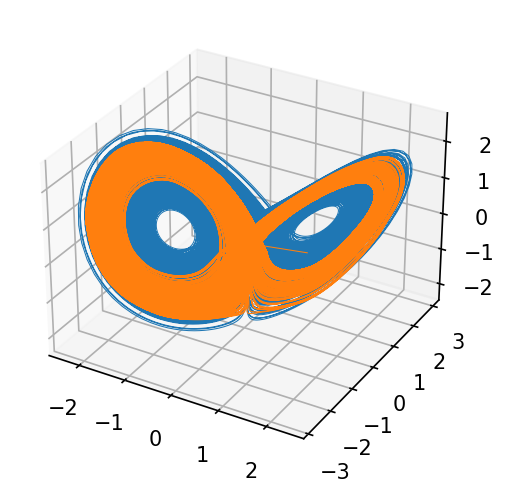

In [267]:
_, data_generated = plot_generated(data, model)
plt.show()

### c)

  0%|          | 0/500 [00:00<?, ?it/s]

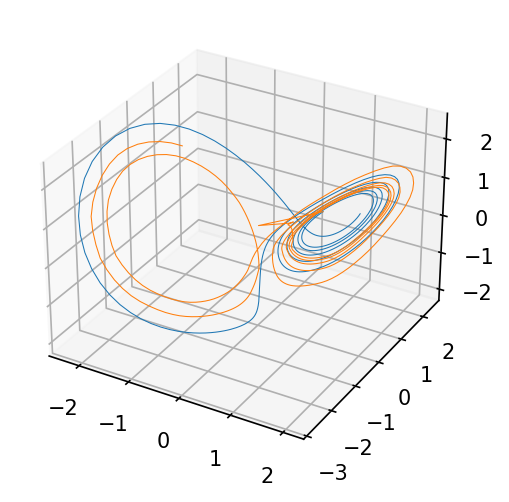

1.0009911060333252

In [274]:
start = np.random.randint(len(data)-500)
ax, data_generated = plot_generated(data[start:start+500], model)
plt.show()

nn.MSELoss()(data[start:start+500], data_generated).item()

### d)

Since the Lorenz-attractor is chaotic, a slightly different value at the second value will result in a trajectory that differs more strongly. But the full generated trajectory shows, that the model did learn the dynamics

### e)

  0%|          | 0/15000 [00:00<?, ?it/s]

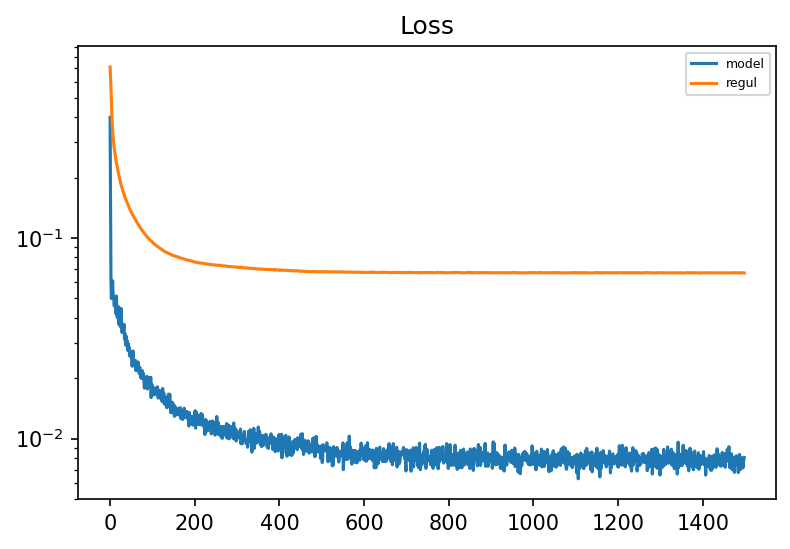

In [232]:
hidden_size = 300
learning_rate = 0.1
L1_reg_strength = 10
epochs = 15000
seq_per_epoch = 200
seq_length = 200


model_lstm = latent_LSTM(observation_size, hidden_size).to(device)
optimizer = optim.Adam(model_lstm.parameters(), lr=learning_rate)
loss_function = nn.MSELoss()

model_lstm, loss_over_time = train(model_lstm, data.to(device), epochs, seq_per_epoch, seq_length, L1_reg_strength, plot_loss=True)


  0%|          | 0/15000 [00:00<?, ?it/s]

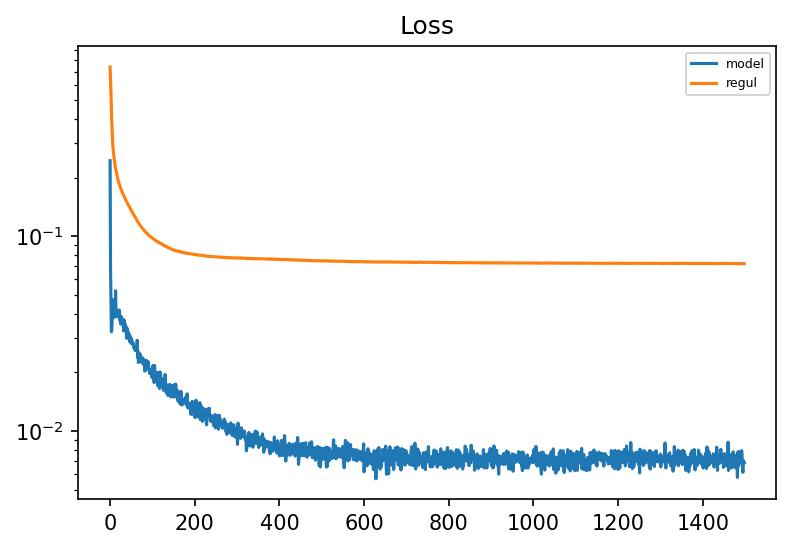

In [235]:
hidden_size = 300
learning_rate = 0.1
L1_reg_strength = 10
epochs = 15000
seq_per_epoch = 200
seq_length = 200


model_gru = latent_GRU(observation_size, hidden_size).to(device)
optimizer = optim.Adam(model_gru.parameters(), lr=learning_rate)
loss_function = nn.MSELoss()

model_gru, loss_over_time = train(model_gru, data.to(device), epochs, seq_per_epoch, seq_length, L1_reg_strength, plot_loss=True)


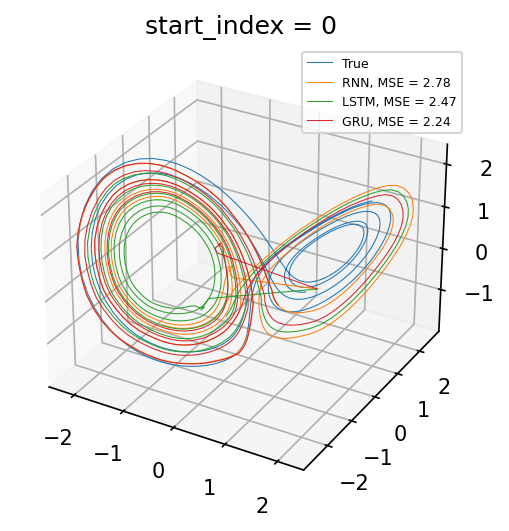

In [269]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax = plot3D(data[start_index:start_index+500], ax, label="True")

start = 0
for m, name in zip([model, model_lstm, model_gru], ["RNN", "LSTM", "GRU"]):
    h0 = torch.randn((1, model.latent_dim), device=device)
    gen = model.generate(500, data[start:start+1].to(device), h0, progress_bar=False)

    error = nn.MSELoss()(data[start:start+500], gen)
    ax = plot3D(gen, ax, label=f"{name}, MSE = {error:.2f}")

plt.title(f"start_index = {start}")
plt.legend()

plt.show()

Different start index:

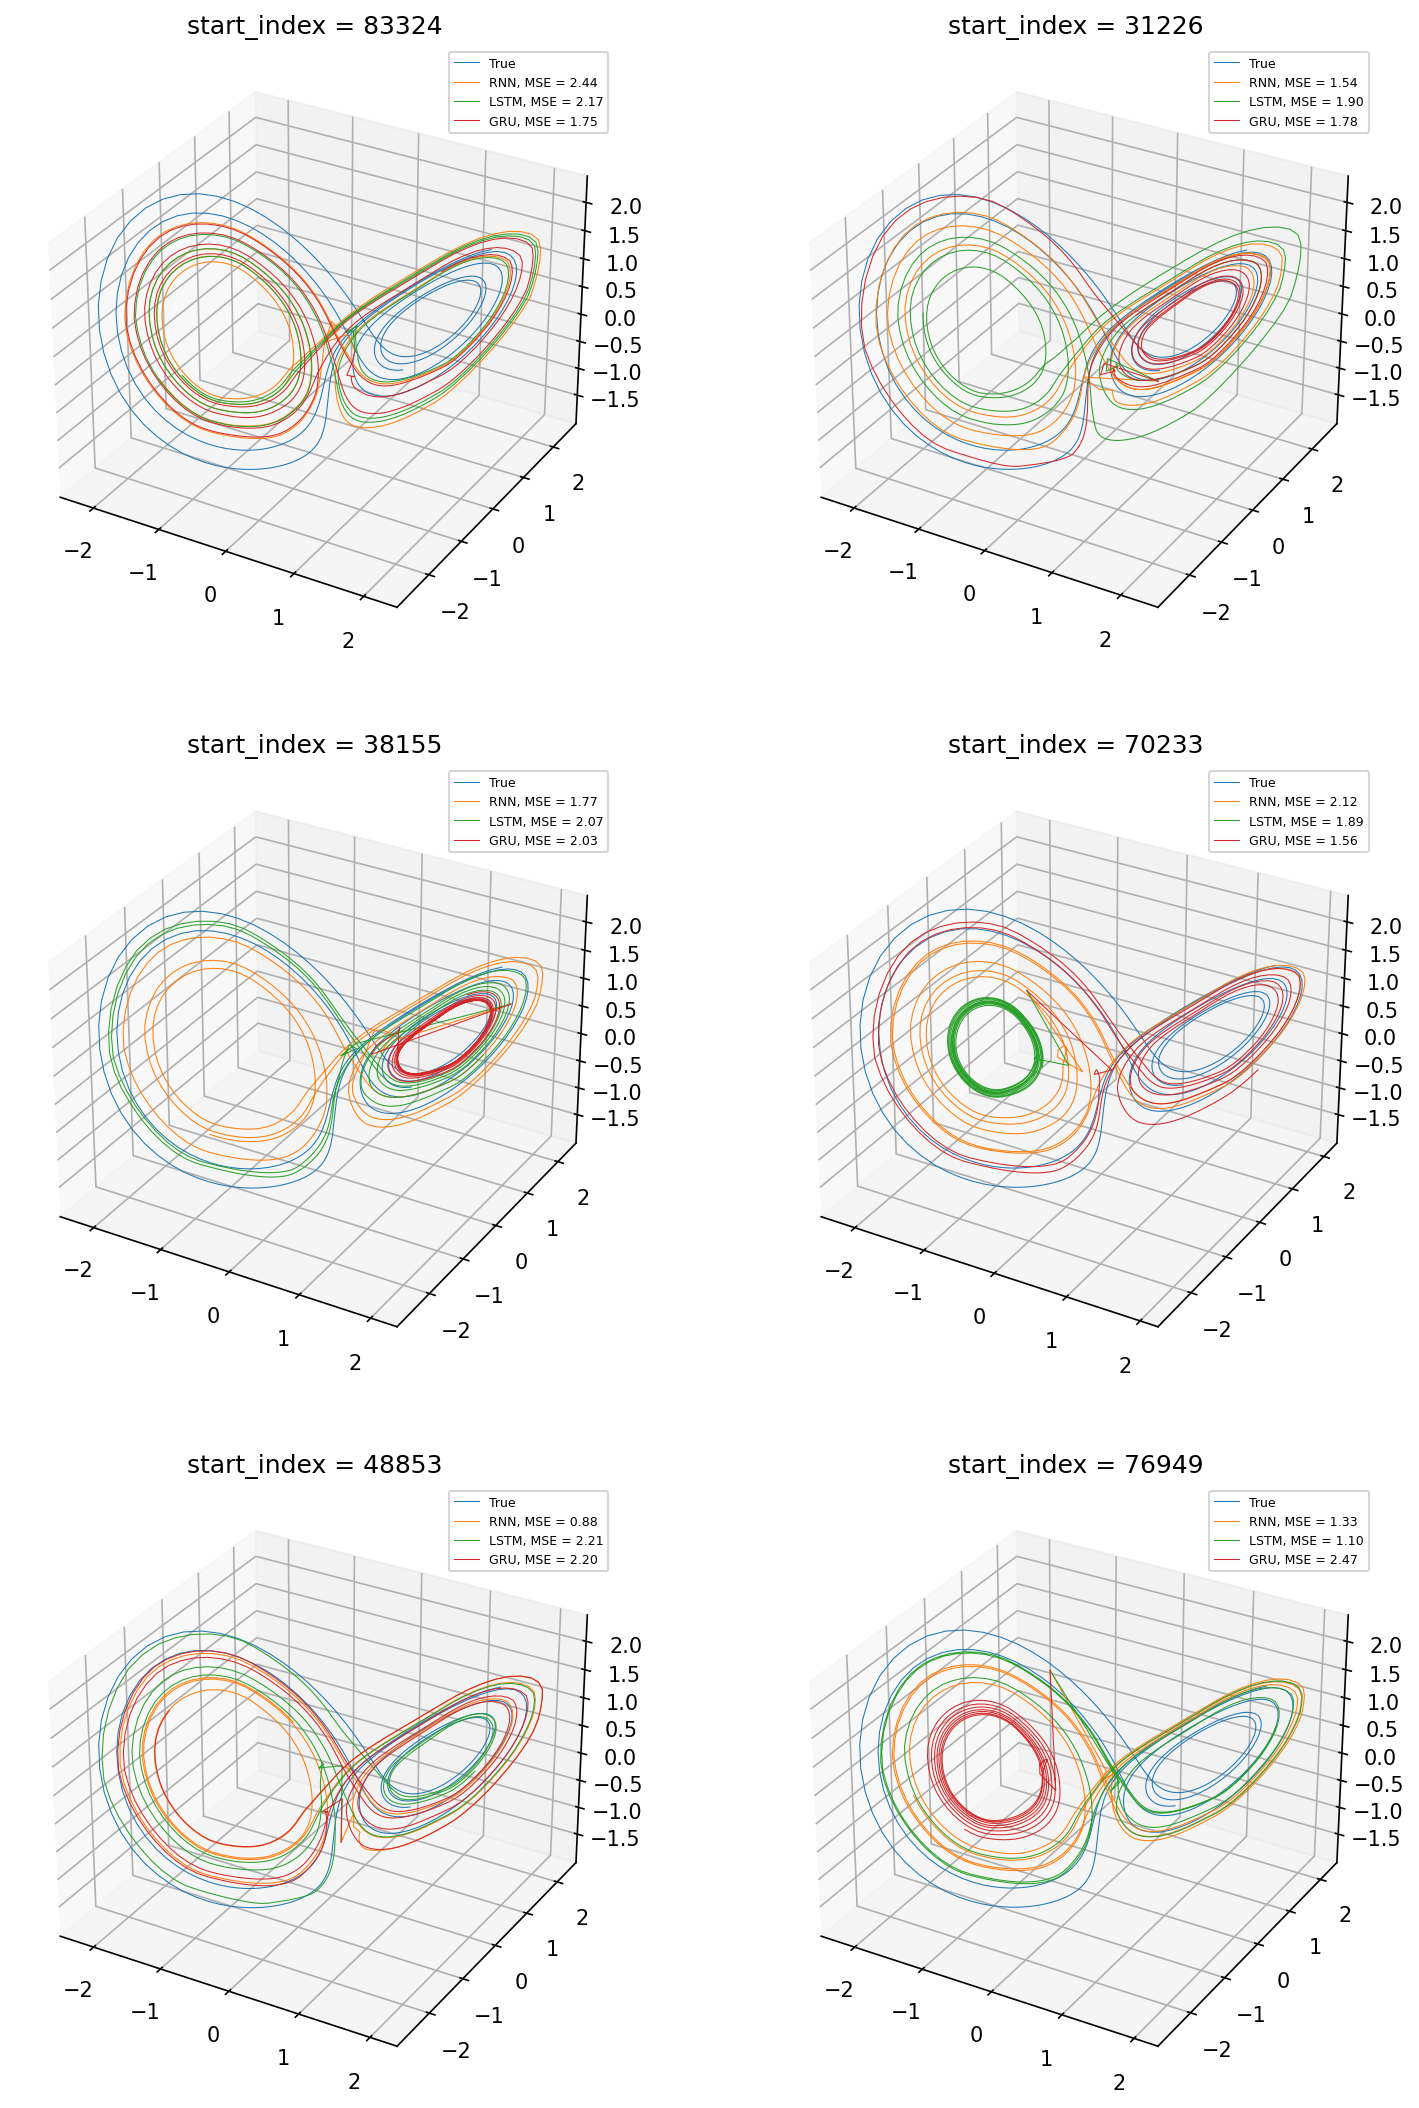

In [262]:
fig = plt.figure(figsize=(12,18))
for i in range(3):
    for j in range(2):
        ax = fig.add_subplot(320 + 2*i+j+1, projection='3d')
        ax = plot3D(data[start_index:start_index+500], ax, label="True")

        start = np.random.randint(len(data)-500)
        for m, name in zip([model, model_lstm, model_gru], ["RNN", "LSTM", "GRU"]):
            h0 = torch.randn((1, model.latent_dim), device=device)
            gen = model.generate(500, data[start:start+1].to(device), h0, progress_bar=False)

            error = nn.MSELoss()(data[start:start+500], gen)
            ax = plot3D(gen, ax, label=f"{name}, MSE = {error:.2f}")

        ax.set_title(f"start_index = {start}")
        ax.legend()

plt.show()